In [45]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

# switch the renderer to use black and white mode and increase the font size for legends
IPythonConsole.drawOptions.useBWAtomPalette()
IPythonConsole.drawOptions.legendFontSize=18


import numpy as np

import rdkit
print(rdkit.__version__)

2024.09.6


In [2]:
import lwreg

# get the base lwreg configuration:
config = lwreg.utils.defaultConfig()
config

{'dbname': './testdb.sqlt',
 'dbtype': 'sqlite3',
 'standardization': 'fragment',
 'removeHs': 1,
 'useTautomerHashv2': 0,
 'registerConformers': 0,
 'numConformerDigits': 3,
 'lwregSchema': ''}

In [3]:
# set the name of the database we'll work with:
config['dbname'] = 'jupyter_data_demo.sqlt'

# and then tell lwreg to use ths configuration as the default in all other commands
# we call in this session:
lwreg.set_default_config(config)

Initialize the database. 
    
**Note** that this erases everything in the current database, so be very careful with this command!

In [4]:
lwreg.initdb()

This will destroy any existing information in the registration database.


  are you sure? [yes/no]:  yes


True

# Register the compounds

In [5]:
# The RDKit standardizer is quite verbose by default, make it be quiet:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.info')

Read in a file containing data exported from ChEMBL. This has bioactivity data as well as SMILES for molecules.

In [6]:
import pandas as pd
df = pd.read_csv('./tutorial_data/S1P1_data.csv')
df.head()

,doc_id,molregno,standard_relation,standard_value,standard_units,standard_flag,standard_type,pchembl_value,canonical_smiles,compound_chembl_id
0,5839,189018,=,82.0,nM,1,EC50,7.09,CCCCCCCCc1ccc(NC(=O)[C@@H](N)COP(=O)(O)O)cc1.O...,CHEMBL332050
1,5839,188442,=,322.1,nM,1,EC50,6.49,CCCCCCCCCCCCCCONC(=O)[C@@H](N)COP(=O)(O)O.OC(=...,CHEMBL115505
2,5839,188375,=,260.0,nM,1,EC50,6.58,CCCCCCc1ccc(NC(=O)[C@H](N)COP(=O)(O)O)cc1.OC(=...,CHEMBL115344
3,5839,188376,=,598.4,nM,1,EC50,6.22,CCCCCCCCCCCCNC(=O)[C@@H](N)COP(=O)(O)O.OC(=O)C...,CHEMBL324358
4,5839,188766,=,12.7,nM,1,EC50,7.90,CCCCCCCCCCCCCCNC(=O)[C@H](N)COP(=O)(O)O.OC(=O)...,CHEMBL332472


Construct the molecules and then register them. Keep track of the molregnos.

This takes a couple of minutes:

In [7]:
ms = [Chem.MolFromSmiles(smi) for smi in df.canonical_smiles]

mrns = lwreg.bulk_register(mols=ms,fail_on_duplicate=False)
len(ms),len(mrns)

(2253, 2253)

# Store the data

Now create a new table to hold the data from our input file.
To do this we're going to be interacting directly with the database instead of using lwreg functions.

We start by asking lwreg to give us a database connection and then create a cursor to use to do our work.

> NOTE that, for performance reasons, lwreg caches the database connection that it uses and keeps it alive.

In [8]:
cn = lwreg.utils.connect(config=config)
curs = cn.cursor()

Create a table with the columns we want:

In [11]:
curs.execute('create table chembl_s1p1_data (molregno integer, doc_id integer, standard_relation text, standard_value real,\
 standard_units text, standard_flag integer, standard_type text, pchembl_value real, compound_chembl_id text)')

Get a version of our data with only the useful columns:

In [12]:
filtered_df = df.drop(columns=['molregno','canonical_smiles'])
filtered_df.head()

,doc_id,standard_relation,standard_value,standard_units,standard_flag,standard_type,pchembl_value,compound_chembl_id
0,5839,=,82.0,nM,1,EC50,7.09,CHEMBL332050
1,5839,=,322.1,nM,1,EC50,6.49,CHEMBL115505
2,5839,=,260.0,nM,1,EC50,6.58,CHEMBL115344
3,5839,=,598.4,nM,1,EC50,6.22,CHEMBL324358
4,5839,=,12.7,nM,1,EC50,7.90,CHEMBL332472


add the molregnos from lwreg to the beginning of each row:

In [13]:
to_add = [[mrn] + filtered_df.iloc[i].to_list() for i,mrn in enumerate(mrns)]
len(to_add)

2253

Integer columns need to be converted to python ints instead of the numpy values that pandas use. This is ugly but unfortunately necessary when working with pandas and sqlite.

In [14]:
import sqlite3
sqlite3.register_adapter(np.int64, int)
sqlite3.register_adapter(np.int32, int)


And now insert that into the database:

In [15]:
qs = ','.join('?'*len(to_add[0]))
sql = f'insert into chembl_s1p1_data values ({qs})'
curs.executemany(sql,to_add)

Finish our transaction and write the data to the database.

In [16]:
cn.commit()

# Retrieve data associated with a structure

Start by querying for a structure:

In [17]:
qres = lwreg.query(smiles='CC(C)Oc1ncc(cc1Cl)c2nnc(s2)c3ccc(CCC(=O)O)cc3C')
qres

[100]

Get the compound structure from lwreg:

In [18]:
mid = qres[0]
res = lwreg.retrieve(id=mid)
mol = Chem.MolFromMolBlock(res[mid][0])

Get the data via a SQL query against our extra data table:

In [19]:
curs.execute('select * from chembl_s1p1_data where molregno=?',(mid,))
rows = curs.fetchall()

# now convert the rows into a list of dicts with column names as keys:
drows = []
for row in rows:
    drow = {}
    for tpl,v in zip(curs.description,row):
        drow[tpl[0]] = v
    drows.append(drow)
drow = drows[0]
drow

{'molregno': 100,
 'doc_id': 31478,
 'standard_relation': '=',
 'standard_value': 2.1,
 'standard_units': 'nM',
 'standard_flag': 1,
 'standard_type': 'EC50',
 'pchembl_value': 8.68,
 'compound_chembl_id': 'CHEMBL212420'}

Display the molecule with its pchembl value:

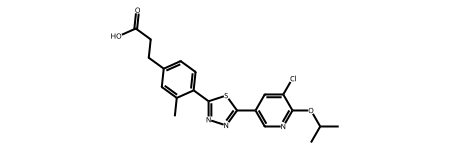

In [20]:
mol.SetProp('ChEMBL ID',drow['compound_chembl_id'])
mol.SetDoubleProp(f'p{drow['standard_type']}',drow['pchembl_value'])

mol

# Retrieve the structures associated with some data

Here we query the data table to find the molregnos which are highly active (pEC50>10):

In [46]:
curs.execute('select molregno,compound_chembl_id,pchembl_value from chembl_s1p1_data where pchembl_value>10\
  order by pchembl_value desc')
rows = curs.fetchall()
len(rows)

146

In [47]:
rows[:3]

[(753, 'CHEMBL2032300', 11.0),
 (24, 'CHEMBL366208', 10.92),
 (693, 'CHEMBL2018176', 10.9)]

We can pass those molregnos to a call to `lwreg.retrieve()`:

In [48]:
res = lwreg.retrieve(ids=[x[0] for x in rows])
len(res)

142

Look at the first few structures:

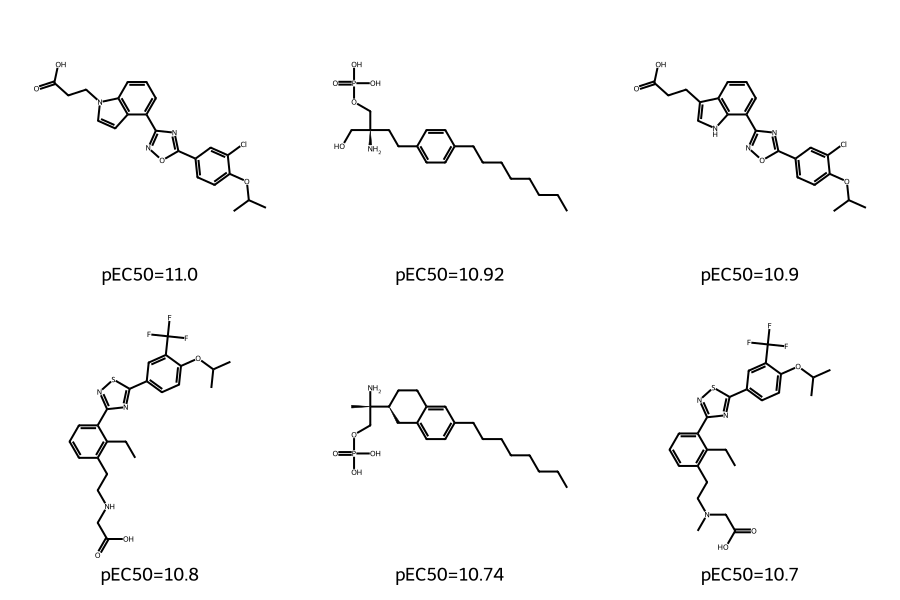

In [49]:
mols = []
legends = []
for mrn,cid,pec50 in rows[:6]:
    mol = Chem.MolFromMolBlock(res[mrn][0])
    mols.append(mol)
    legends.append(f'pEC50={pec50}')
Draw.MolsToGridImage(mols,legends=legends,subImgSize=(300,300))

## Querying the structures directly

It's possible to retrieve the structural data together with the results in a single SQL query:

In [50]:
curs.execute('select molregno,compound_chembl_id,pchembl_value,molblock from chembl_s1p1_data \
  join molblocks using (molregno)\
  where pchembl_value>10\
  order by pchembl_value desc')
rows = curs.fetchall()
len(rows)

146

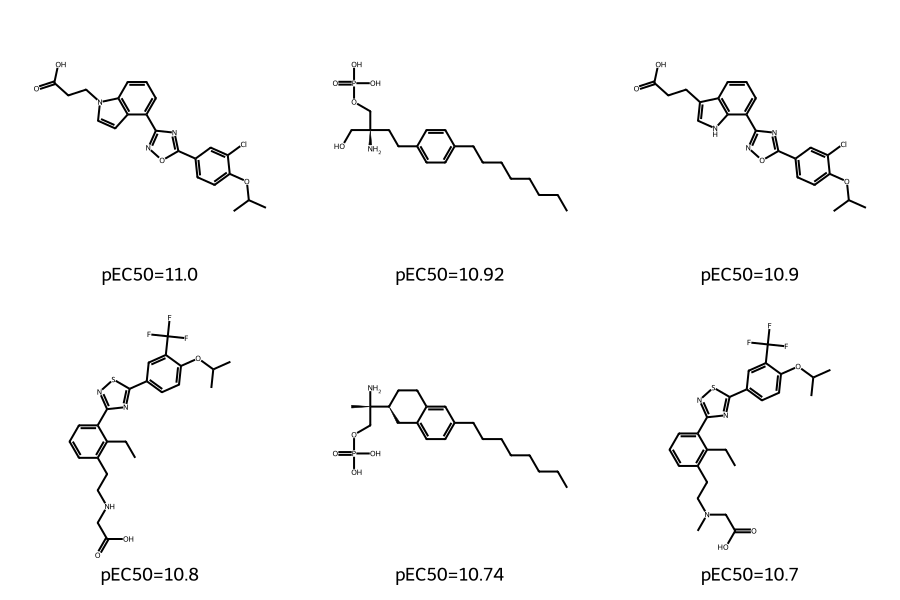

In [51]:
mols = []
legends = []
for mrn,cid,pec50,molb in rows[:6]:
    mol = Chem.MolFromMolBlock(molb)
    mols.append(mol)
    legends.append(f'pEC50={pec50}')
Draw.MolsToGridImage(mols,legends=legends,subImgSize=(300,300))